In [1]:
#import necessary labraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display


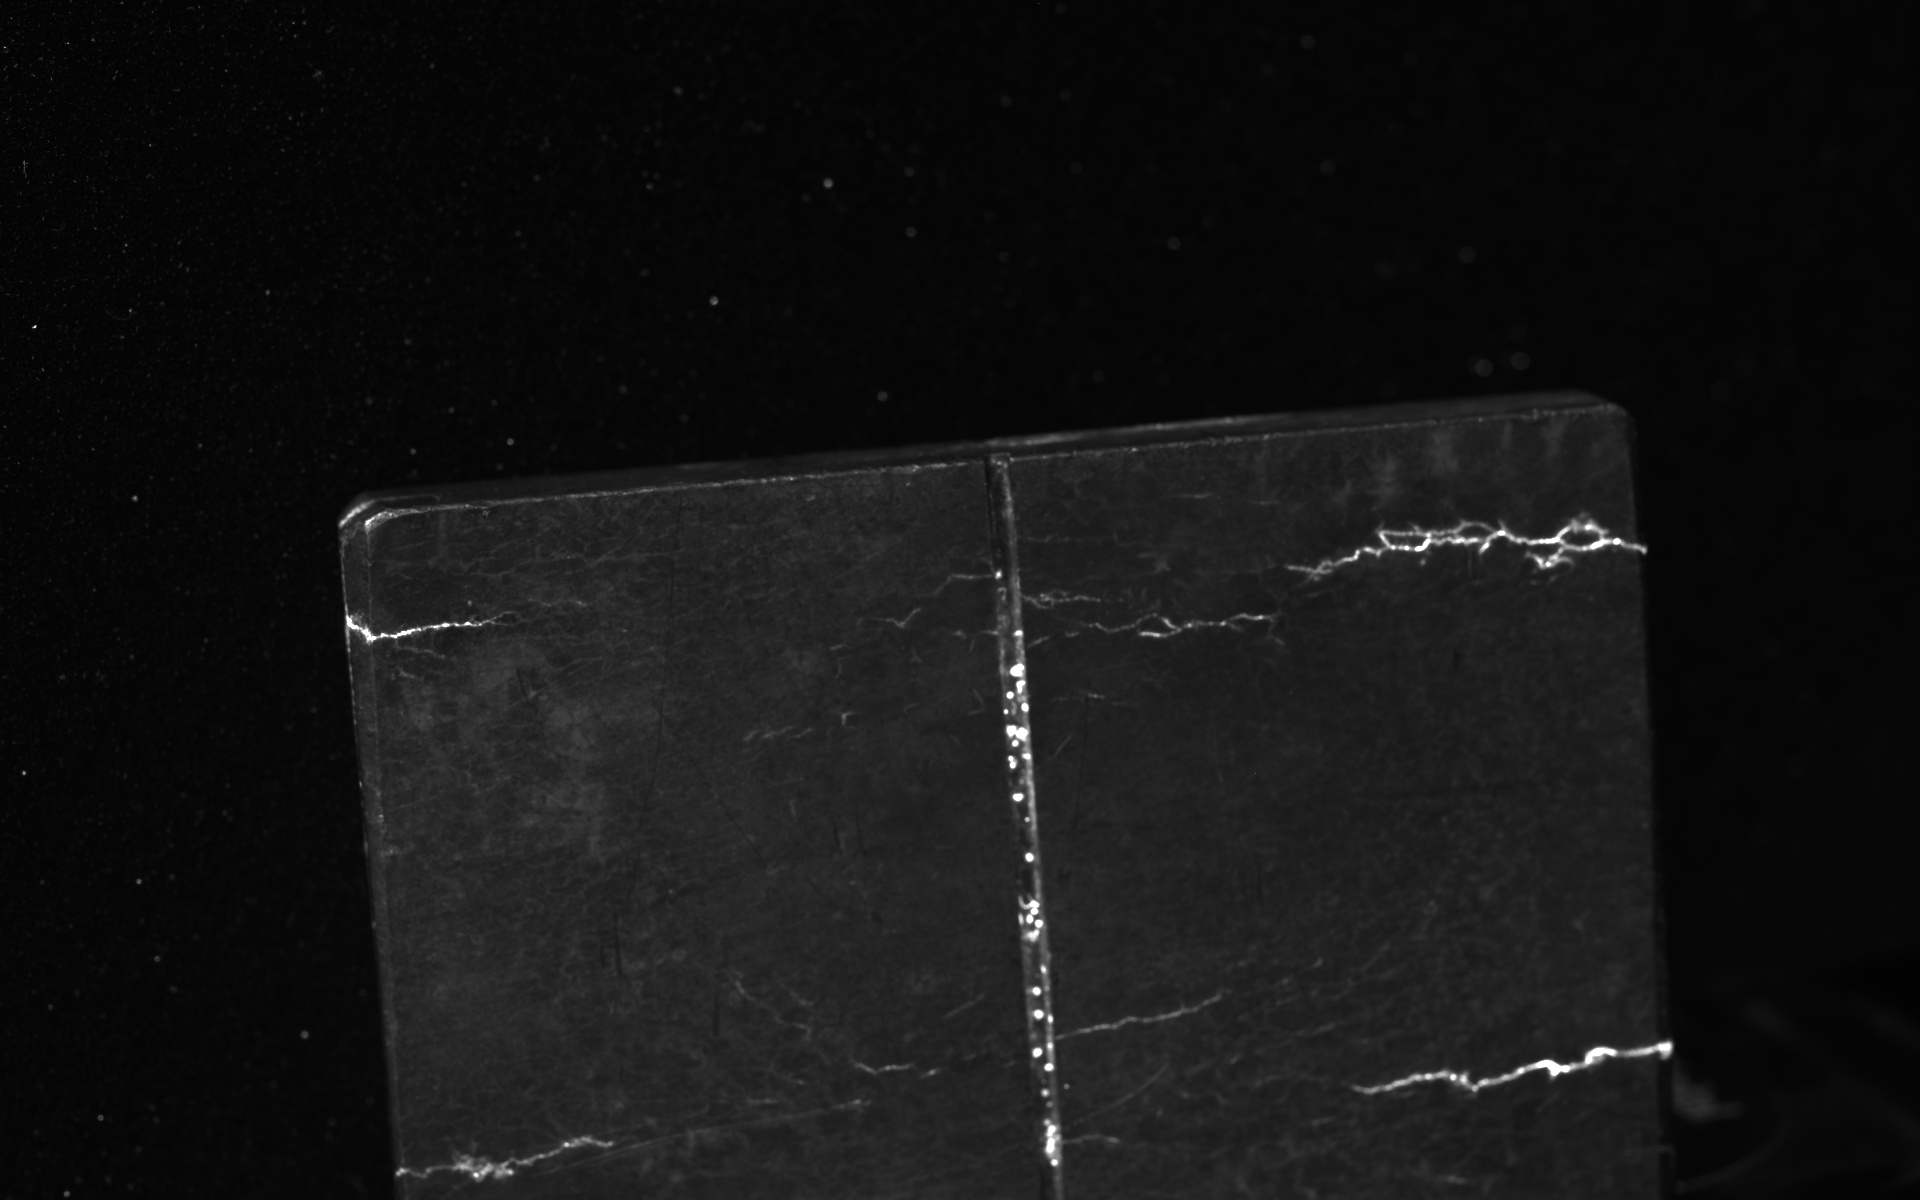

In [2]:
def imshow(img, axes=None):
    if axes is None:
        ret, encoded = cv2.imencode('.jpg', img)
        display(Image(encoded))
    else:
        axes.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes.axis('off')

img = cv2.imread('test_image1.bmp')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imshow(gray)


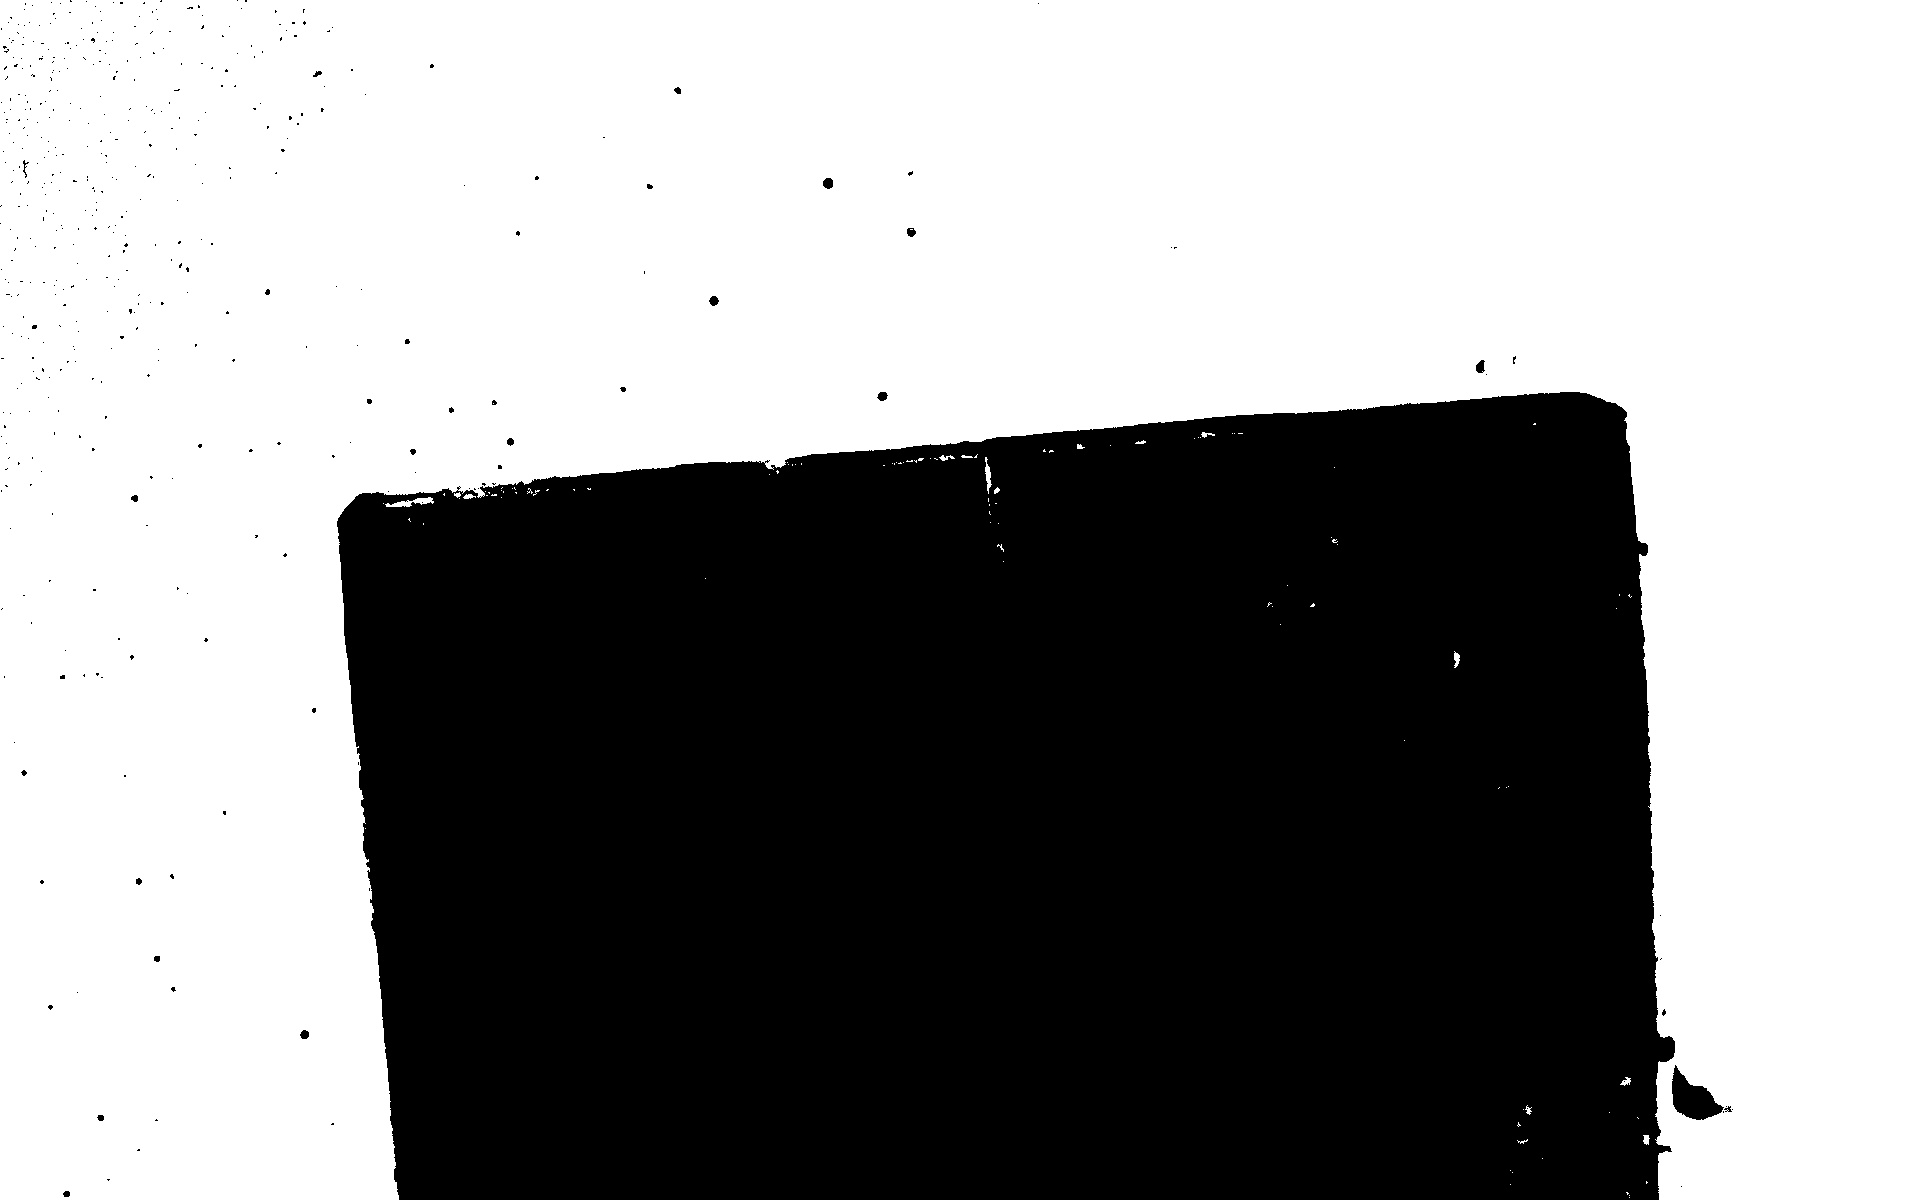

In [3]:
ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

imshow(bin_img)

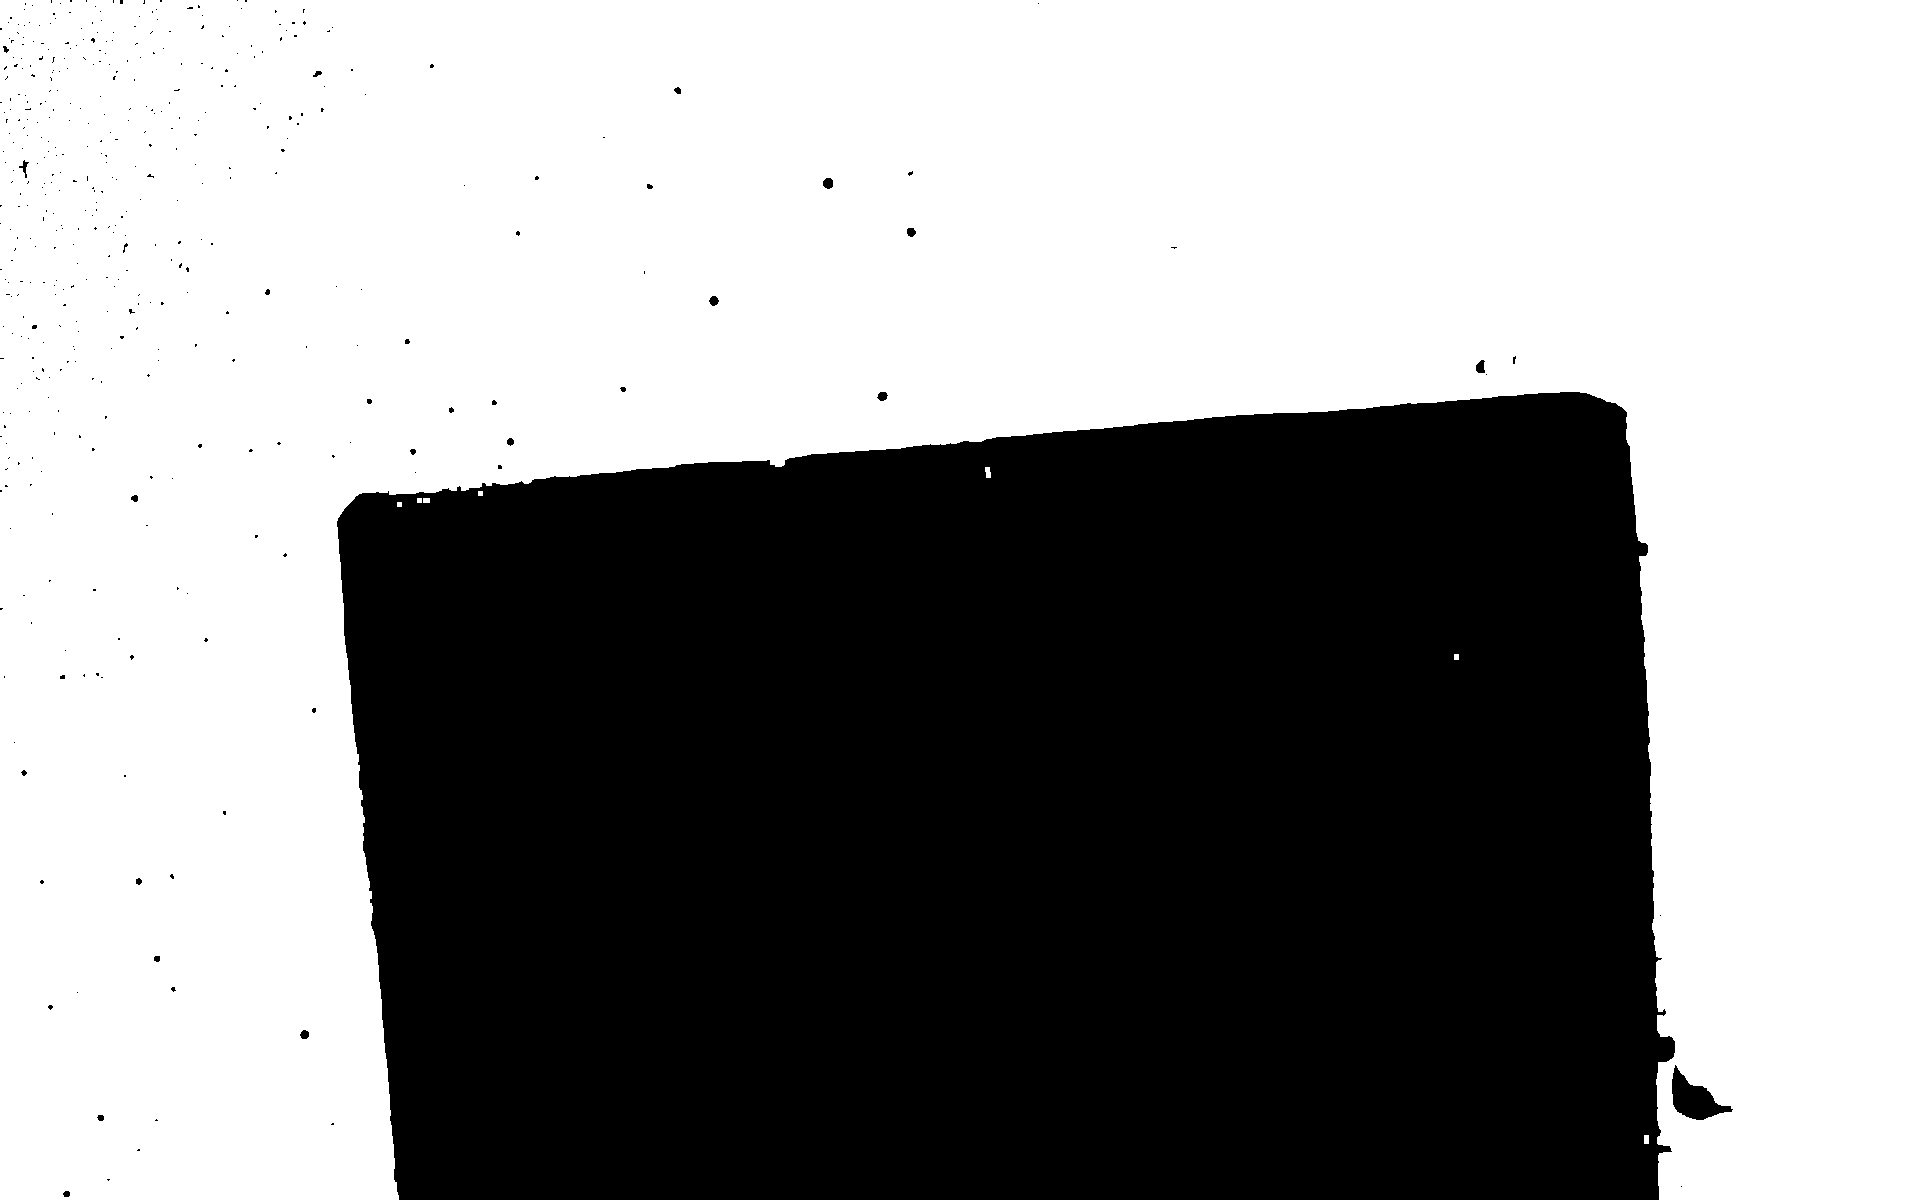

In [4]:
# noise removal 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=2)

imshow(bin_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


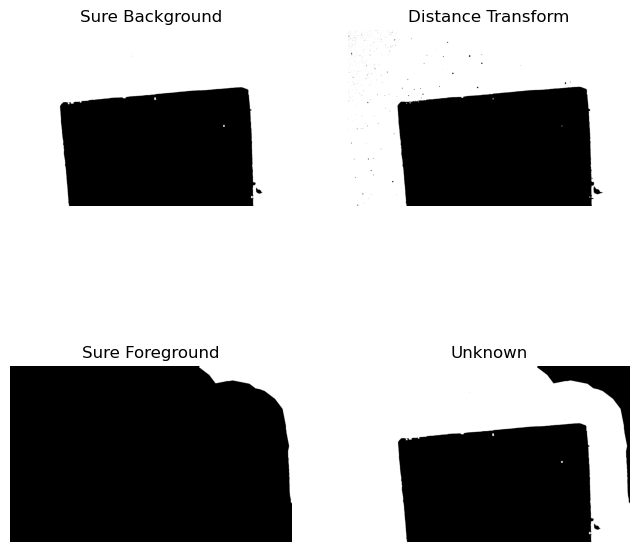

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
#sure bg
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0, 0])
axes[0, 0].set_title('Sure Background')


# Distance transform 
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0, 1])
axes[0, 1].set_title('Distance Transform')


ret, sure_fg = cv2.threshold(dist, 0.50 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
imshow(sure_fg, axes[1, 0])
axes[1, 0].set_title('Sure Foreground')

unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1, 1])
axes[1, 1].set_title('Unknown')
plt.show()


[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


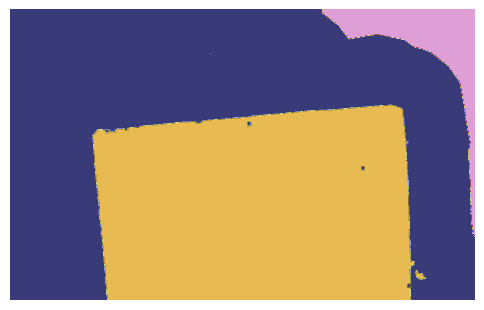

In [6]:
# Marker labelling 
# sure foreground  
ret, markers = cv2.connectedComponents(sure_fg)
print(markers)

# Add one to all labels so that background is not 0, but 1 
markers += 1
# mark the region of unknown with zero 
markers[unknown == 255] = 0

fig,ax = plt.subplots(figsize=(6, 6,))
ax.imshow(markers, cmap="tab20b") 
ax.axis('off')
plt.show()

### Watershed Algo

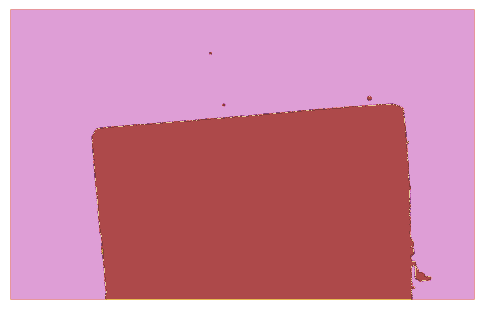

In [7]:
# watershed Algorithm 
markers = cv2.watershed(img, markers)

fig,ax = plt.subplots(figsize=(6, 6,))
ax.imshow(markers, cmap="tab20b") 
#ax.imshow(markers, cmap='YlGnBu')
ax.axis('off')
plt.show()

In [8]:
labels = np.unique(markers)
print(labels)

[-1  1  2]


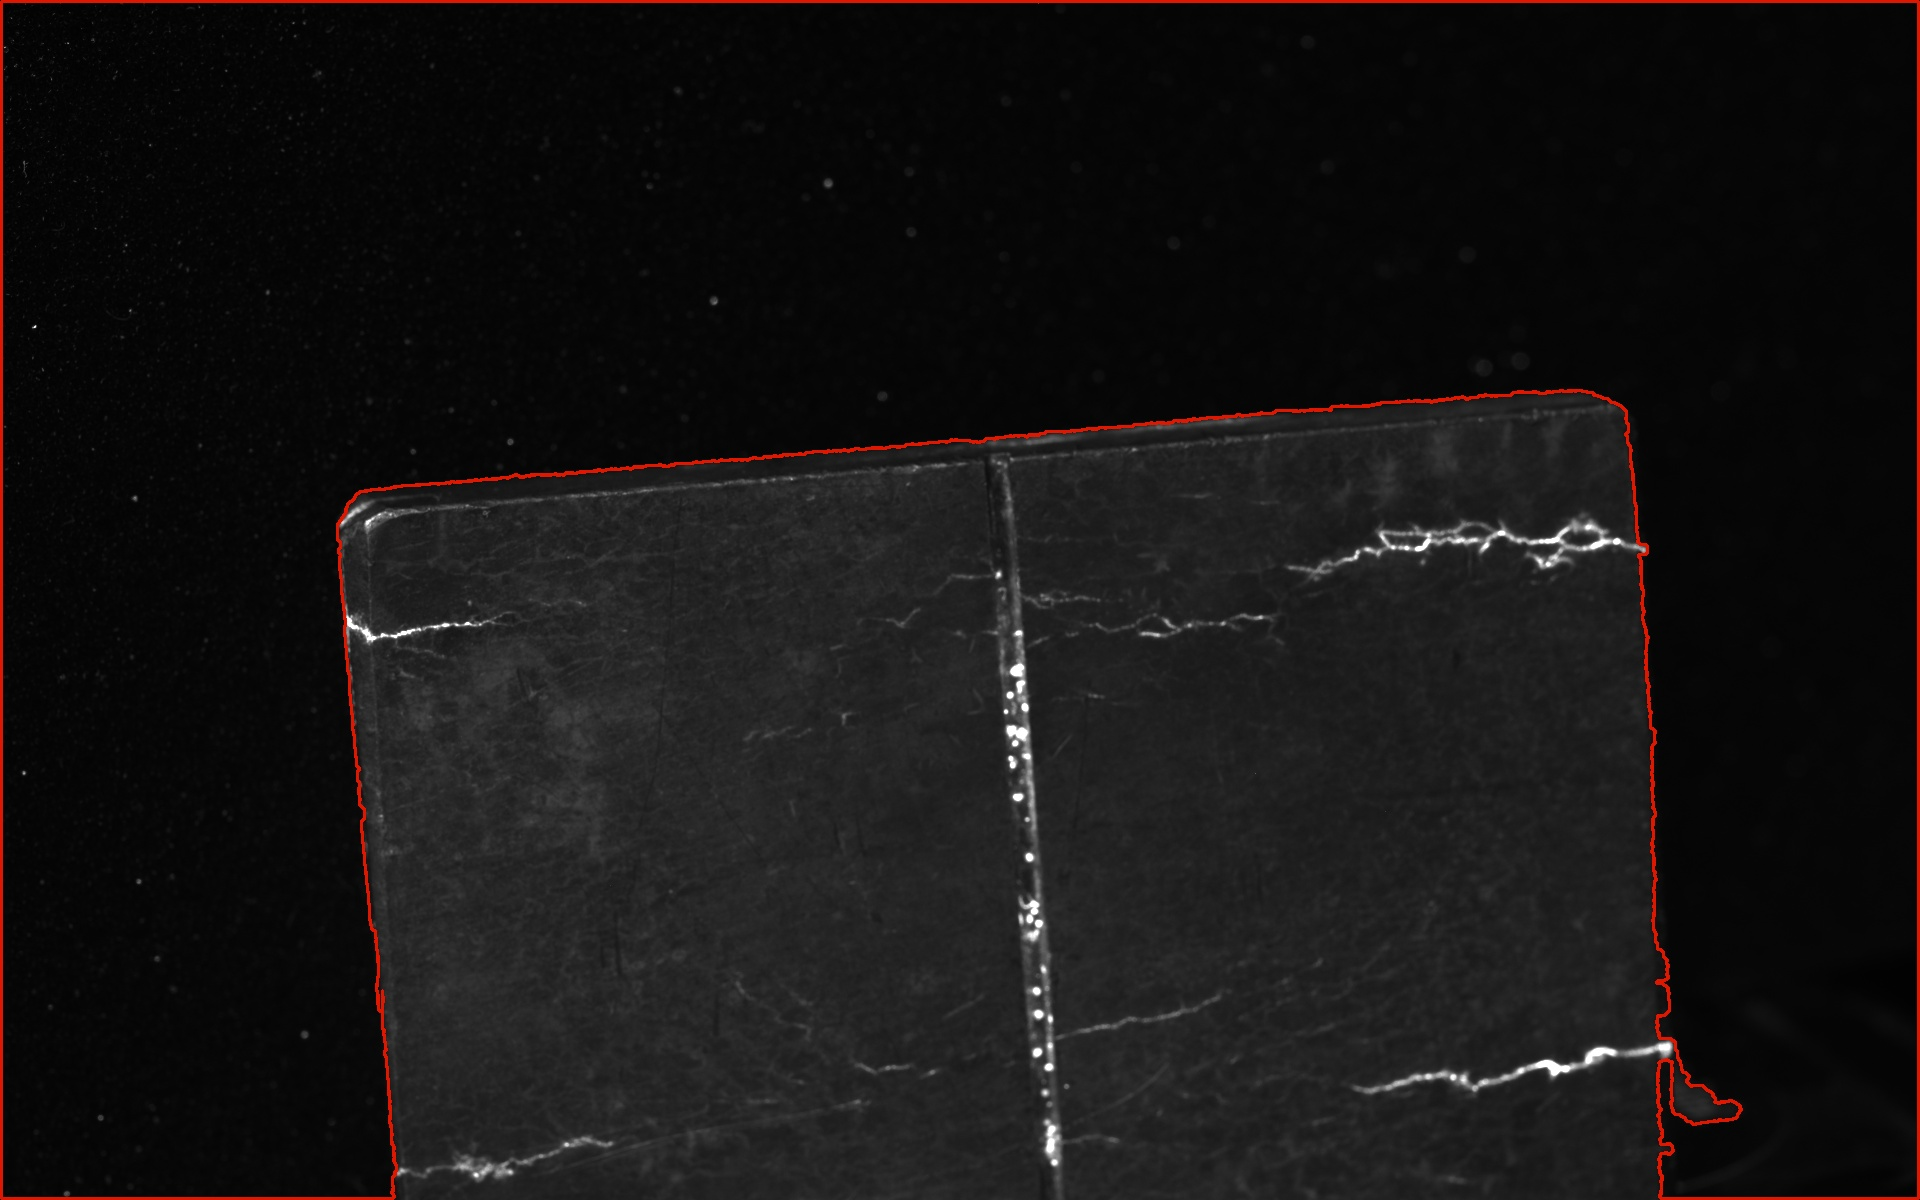

In [9]:
coins = []
for label in labels[2:]:
     
    # Create a binary image in which only the area of the label is in the foreground  
    #and the rest of the image is in the background 
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    
    # Perform contour extraction on the created binary image 
    contour, heirarchy = cv2.findContours(target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coins.append(contour[0])

cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)


### Code test 2


In [10]:
import cv2
import math
import numpy as np
import scipy.ndimage

def orientated_non_max_suppression(mag, ang):
    ang_quant = np.round(ang / (np.pi/4)) % 4
    winE = np.array([[0, 0, 0],[1, 1, 1], [0, 0, 0]])
    winSE = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    winS = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]])
    winSW = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])

    magE = non_max_suppression(mag, winE)
    magSE = non_max_suppression(mag, winSE)
    magS = non_max_suppression(mag, winS)
    magSW = non_max_suppression(mag, winSW)

    mag[ang_quant == 0] = magE[ang_quant == 0]
    mag[ang_quant == 1] = magSE[ang_quant == 1]
    mag[ang_quant == 2] = magS[ang_quant == 2]
    mag[ang_quant == 3] = magSW[ang_quant == 3]
    return mag

def non_max_suppression(data, win):
    data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')
    data_max[data != data_max] = 0
    return data_max

# start calulcation
gray_image = cv2.imread(r'test_image1.bmp', 0)

with_nmsup = True #apply non-maximal suppression
fudgefactor = 1.3 #with this threshold you can play a little bit
sigma = 21 #for Gaussian Kernel
kernel = 2*math.ceil(2*sigma)+1 #Kernel size

gray_image = gray_image/255.0
blur = cv2.GaussianBlur(gray_image, (kernel, kernel), sigma)
gray_image = cv2.subtract(gray_image, blur)

# compute sobel response
sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
mag = np.hypot(sobelx, sobely)
ang = np.arctan2(sobely, sobelx)

# threshold
threshold = 4 * fudgefactor * np.mean(mag)
mag[mag < threshold] = 0

#either get edges directly
if with_nmsup is False:
    mag = cv2.normalize(mag, 0, 255, cv2.NORM_MINMAX)
    kernel = np.ones((5,5),np.uint8)
    result = cv2.morphologyEx(mag, cv2.MORPH_CLOSE, kernel)
    cv2.imshow('im', result)
    #cv2.waitKey()
    #cv2.waitKey(0) 
    cv2.waitKey(1000) 
    # closing all open windows 
    cv2.destroyAllWindows() 
#or apply a non-maximal suppression
else: 

    # non-maximal suppression
    mag = orientated_non_max_suppression(mag, ang)
    # create mask
    mag[mag > 0] = 255
    mag = mag.astype(np.uint8)

    kernel = np.ones((5,5),np.uint8)
    result = cv2.morphologyEx(mag, cv2.MORPH_CLOSE, kernel)

    cv2.imshow('im', result)
    #cv2.waitKey()
    #cv2.waitKey(0) 
    cv2.waitKey(1000)
    # closing all open windows 
    cv2.destroyAllWindows() 

/var/folders/xr/x_j1pnw55ms124rjm48zs7k00000gn/T/ipykernel_2771/1903383813.py:25: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  data_max = scipy.ndimage.filters.maximum_filter(data, footprint=win, mode='constant')
